In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from functools import reduce
from torch.nn import functional as F

In [3]:
n = 100 # resolution plot
k = 2 # dimension
a = 10 # limit for a->oo better approx

h = torch.linspace(-5, 5, n)
h0 = torch.stack(torch.meshgrid([h]*k),-1)
print("h:", h0.shape)

# data to fit
xs = [
    torch.tensor([-2., -2.]), 
    torch.tensor([-2., +2.]), 
    torch.tensor([+2., -2.]),
    torch.tensor([+2., +2.])
]

h: torch.Size([100, 100, 2])


c:\ProgramData\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


params 1+: torch.Size([8, 2]) torch.Size([8])
params 1-: torch.Size([8, 2]) torch.Size([8])
h 1+: torch.Size([100, 100, 8])
h 1-: torch.Size([100, 100, 8])


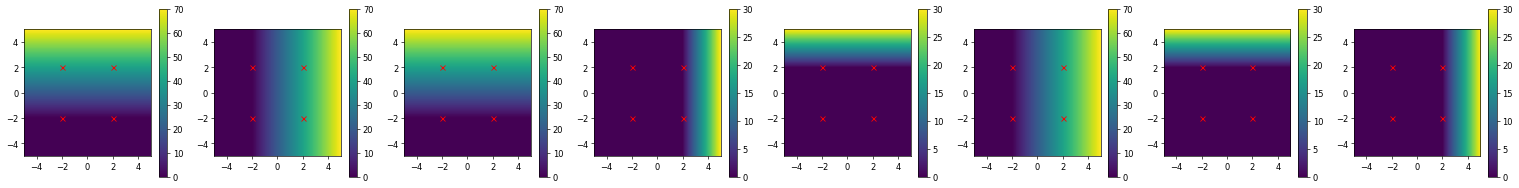

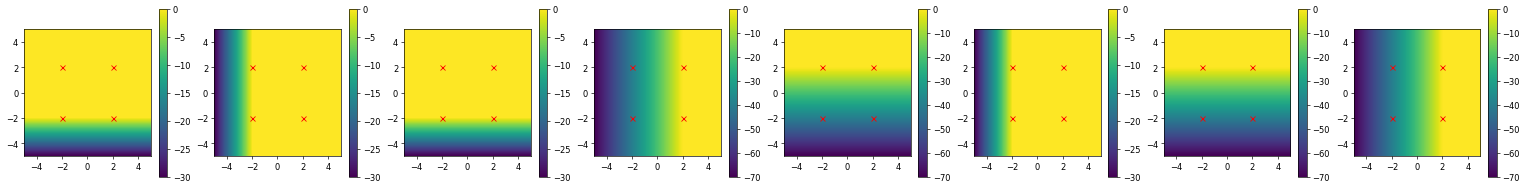

In [4]:
# layer 1
w1p = a*torch.concat([torch.eye(k)]*len(xs))
#w1p = a*torch.concat([torch.tensor([[1.,1.],[1., 0.]])]*len(xs))
b1p = -a*(torch.concat(xs))

w1n = a*torch.concat([torch.eye(k)]*len(xs))
b1n = -a*torch.concat(xs)

print("params 1+:", w1p.shape, b1p.shape)
print("params 1-:", w1n.shape, b1n.shape)

h1p = torch.relu(F.linear(h0, w1p, b1p))
h1n = -torch.relu(-F.linear(h0, w1n, b1n))
print("h 1+:", h1p.shape)
print("h 1-:", h1n.shape)

# plot
for h1 in (h1p, h1n):
    plt.figure(figsize=(4*h1.shape[-1], 8), dpi=60)
    for i in range(h1.shape[-1]):
        plt.subplot(2, h1.shape[-1], i+1)
        plt.imshow(h1[..., i], extent=(-5, 5, -5, 5), origin='lower')
        for x in xs: plt.plot(x[1], x[0], 'rx')
        plt.colorbar()
plt.show()

params 1+: torch.Size([4, 8]) torch.Size([1])
params 1-: torch.Size([4, 8]) torch.Size([1])
h 2+: torch.Size([100, 100, 4])
h 2-: torch.Size([100, 100, 4])


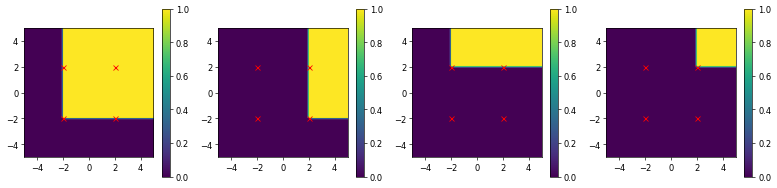

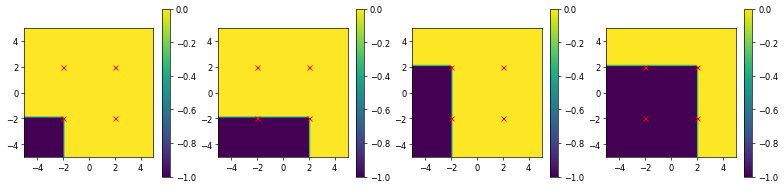

In [5]:
# layer 2
w2p = torch.kron(torch.eye(len(xs)), torch.tensor([[1,1]]))
b2p = torch.tensor([1.])
w2n = torch.kron(torch.eye(len(xs)), torch.ones((1,k)))
b2n = torch.tensor([-1.])

print("params 1+:", w2p.shape, b2p.shape)
print("params 1-:", w2n.shape, b2n.shape)

h2p = torch.relu(F.linear(h1n, w2p, b2p))
h2n = -torch.relu(-F.linear(h1p, w2n, b2n))
print("h 2+:", h2p.shape)
print("h 2-:", h2n.shape)

# plot
for h2 in (h2p, h2n):
    plt.figure(figsize=(4*h2.shape[-1], 8), dpi=60)
    for i in range(h2.shape[-1]):
        plt.subplot(2, h2.shape[-1], i+1)
        plt.imshow(h2[..., i], extent=(-5, 5, -5, 5), origin='lower')
        for x in xs: plt.plot(x[1], x[0], 'rx')
        plt.colorbar()
plt.show()

h 3: torch.Size([100, 100, 1])


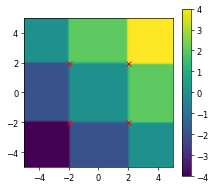

In [6]:
# last layer
b3 = torch.tensor([0.])
w3 = torch.tensor([[
    1., 1., 1., 1., 
    1., 1., 1., 1.
]])

h3 = F.linear(torch.cat((h2p, h2n), -1), w3, b3)
print("h 3:", h3.shape)

# plot
plt.figure(figsize=(4*h3.shape[-1], 8), dpi=60)
for i in range(h3.shape[-1]):
    plt.subplot(2, h3.shape[-1], i+1)
    plt.imshow(h3[..., i], extent=(-5, 5, -5, 5), origin='lower')
    for x in xs: plt.plot(x[1], x[0], 'rx')
    plt.colorbar()
plt.show()

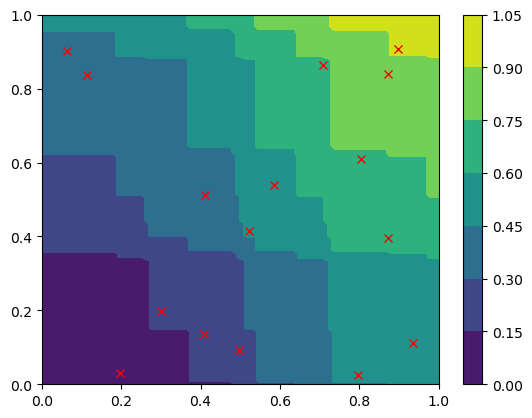

In [53]:
def f(x, n=16):
    dim = x.shape[-1]
    points = torch.rand((n, dim))
    res = torch.zeros(x.shape[:-1])
    for p in points:
        res = torch.where((x>p).any(-1), res+1, res)
        res = torch.where((x>p).all(-1), res+1, res)
    return res/(2*n)


X = torch.stack(torch.meshgrid([torch.linspace(0, 1, 100)]*2),-1)
Y = f(X)
plt.contourf(X[...,0].numpy(), X[...,1].numpy(), Y.numpy())
plt.colorbar()
plt.plot(points[:,0], points[:,1], "xr")
plt.show()

In [55]:
from monotonic import MonotonicLinear
import test_utils

n = 4
x = torch.rand((1024, n))
y = f(x)

models = {
    "relu 2 layers":nn.Sequential(
        MonotonicLinear(4, DIM, pre_activation=nn.Identity()),
        MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
        MonotonicLinear(DIM, 1, pre_activation=nn.ReLU()),
    ),
    "relu 3 layers":nn.Sequential(
        MonotonicLinear(4, DIM, pre_activation=nn.Identity()),
        MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
        MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
        MonotonicLinear(DIM, 1, pre_activation=nn.ReLU()),
    )
}

ModuleNotFoundError: No module named 'monotonic'

In [ ]:
def run_test(models, test_case, device='cuda', max_steps=10000, lr=0.01, early_stop_thr=0.0, copy=True):
    x, y = get_data(test_case)
    if copy:
        models = {name: deepcopy(model) for name, model in models.items()}
    models, losses = train(models, x, y, device, max_steps, lr, early_stop_thr)
    models = {name: model.cpu() for name, model in models.items()}
    plot_results(models, x, y, losses)
    return models, x, y, losses

In [40]:
torch.tril(torch.ones(6, 6), 2)

tensor([[1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [ ]:
input_dim = 2
hidden_dim = 256
output_dim = 1
layers = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    #nn.ReLU()
    #nn.Linear(hidden_dim, hidden_dim)
    nn.ReLU(),
    nn.Linear(hidden_dim, output_dim)
    
)

def getgrad(x):
    x.requires_grad_(True)
    grad = torch.autograd.grad(
        outputs=layers(x),
        inputs=x,
        grad_outputs=torch.ones(x.shape[0], 1),
        create_graph=True,
        retain_graph=True,
    )[0].reshape(x.shape[0], -1)
    return grad

In [ ]:
def lb(layers):
    weights = [l.weight for l in layers if isinstance(l, nn.Linear)]
    Amin, Amax = torch.ones(1, 1), torch.ones(1, 1)
    for i, w in enumerate(weights):
        if i == 0: w = w[:, :1]
        Amin, Amax = (
            torch.minimum(w * Amin, w * Amax).clamp(max=0).sum(dim=-1).unsqueeze(0),
            torch.maximum(w * Amin, w * Amax).clamp(min=0).sum(dim=-1).unsqueeze(0)
        )
    return Amin

(0.0, 5.0)

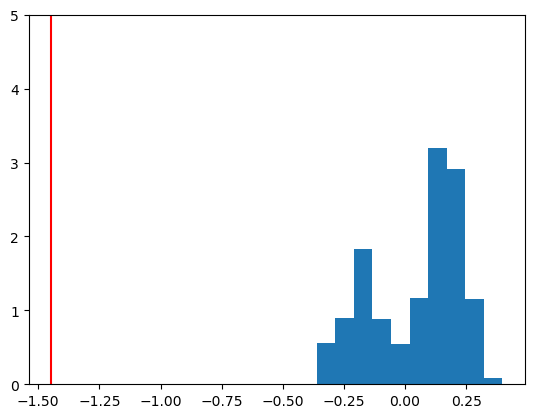

In [ ]:
x = torch.randn(1024, 2)
g, _ = getgrad(x).T.detach()
Amin = lb(layers)
plt.hist(g, density=True)
plt.vlines(Amin.item(), 0, 100, color='r')
plt.ylim(0, 5)

In [ ]:
from tqdm import tqdm
losses = []
opt = torch.optim.Adam(layers.parameters(), lr=0.001)
for i in (pbar:=tqdm(range(10000))):
    x = torch.randn(128, 2, requires_grad=True)
    grad = torch.autograd.grad(
        outputs=layers(x),
        inputs=x,
        grad_outputs=torch.ones(128, 1),
        create_graph=True,
        retain_graph=True,
    )[0].reshape(128, -1)

    loss = -(grad[:, 0]/(layers[-1].weight.max()+1e-8)).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(grad[:, 0].mean().detach().item())
    rmse = sum(losses[-10:])/10
    if i%10==0:
        pbar.set_postfix({'rmse': rmse})

plt.plot(losses)

c:\ProgramData\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


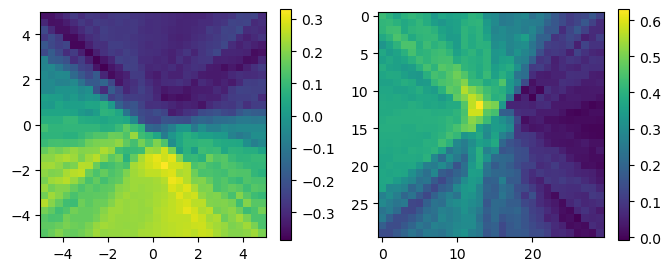

In [ ]:
n = 30
x = torch.linspace(-5, 5, n)
y = torch.linspace(-5, 5, n)
g = getgrad(
    torch.stack(torch.meshgrid(x, y), -1).reshape(-1, 2)
).reshape(n, n, 2).detach().numpy()

g1, g2 = g[..., 0], g[..., 1]

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(g1, extent=[-5, 5, -5, 5], origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(g2)
plt.colorbar()
plt.show()

100%|██████████| 10000/10000 [00:20<00:00, 491.52it/s, rmse=-22.8]


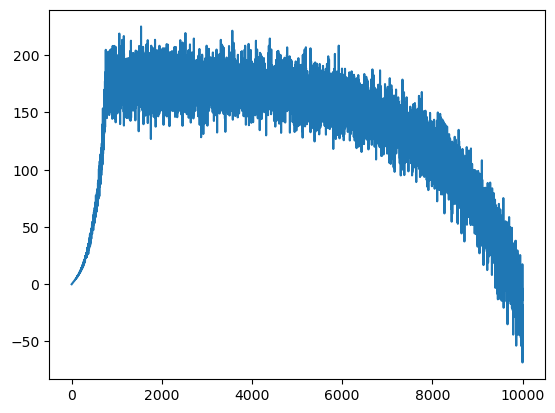

In [ ]:
from tqdm import tqdm
losses = []
opt = torch.optim.Adam(layers.parameters(), lr=0.001)
for i in (pbar:=tqdm(range(10000))):
    x = torch.randn(128, 2, requires_grad=True)
    grad = torch.autograd.grad(
        outputs=layers(x),
        inputs=x,
        grad_outputs=torch.ones(128, 1),
        create_graph=True,
        retain_graph=True,
    )[0].reshape(128, -1)

    loss = -(grad[:, 0]/(layers[-1].weight.max()+1e-8)).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(grad[:, 0].mean().detach().item())
    rmse = sum(losses[-10:])/10
    if i%10==0:
        pbar.set_postfix({'rmse': rmse})

plt.plot(losses)

-265.37244 218.2548
-33.902206 28.272009


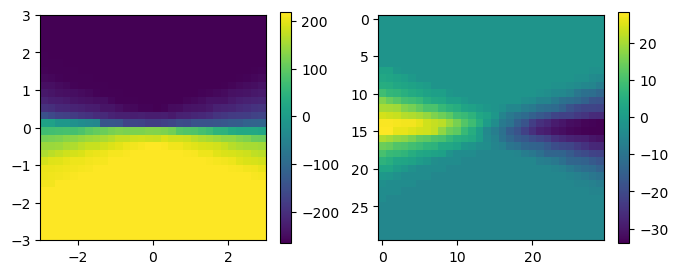

In [ ]:
n = 30
x = torch.linspace(-3, 3, n)
y = torch.linspace(-3, 3, n)
g = getgrad(
    torch.stack(torch.meshgrid(x, y), -1).reshape(-1, 2)
).reshape(n, n, 2).detach().numpy()

g1, g2 = g[..., 0], g[..., 1]
print(g1.min(), g1.max())
print(g2.min(), g2.max())

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(g1, extent=[-3, 3, -3, 3], origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(g2)
plt.colorbar()
plt.show()